<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
# нужно загрузить, чтобы работало в kaggle
!pip install gdown

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import gdown
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
%matplotlib inline

In [ ]:
# Download some attributes

!gdown --id 1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y
To: /kaggle/working/lfw_attributes.txt
100%|███████████████████████████████████████| 14.9M/14.9M [00:00<00:00, 144MB/s]


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

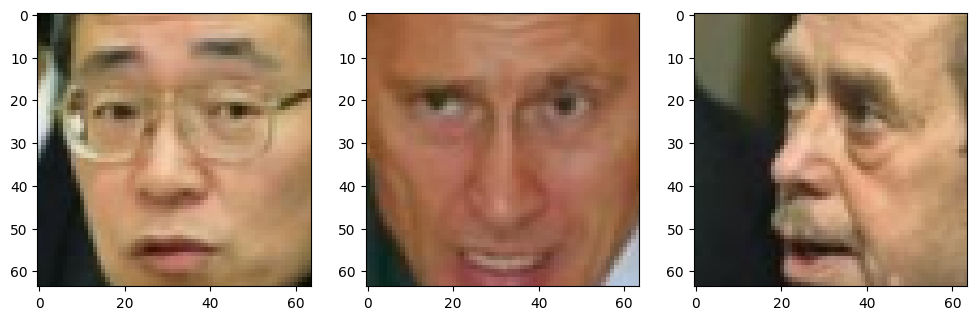

In [ ]:
# <тут Ваш код>
from sklearn.model_selection import train_test_split
import random

# переведем данные в Tensor
data = torch.FloatTensor(data)

# разбиваем на train/val
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=batch_size, num_workers=4)

#
# print(len(train_photos))
# print(train_photos.shape)
# print(train_photos)
# print(val_photos.shape)
# print(train_photos[0])
# print(train_attrs)

# посмотрим на несколько случайных изображений
_, axes = plt.subplots(1,3, figsize=(12, 6))
for ind in range(3):
    num = random.choice(range(len(val_photos)))
    axes[ind].imshow(val_photos[num])

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
latent_code_size = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #<определите архитектуры encoder и decoder>
        # Обратите внимание на формат, в котором функция fetch() возвращает data

        # encoder
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(in_features=2048, out_features=latent_code_size*2)


        # decoder

        self.de_fc = nn.Linear(in_features=latent_code_size, out_features=2048)

        self.deconv_block_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.deconv_block_1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(3)
        )

        self.flatten = nn.Flatten()

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std)    # `randn_like` as we need the same size
        sample = mu + (eps * std)      # sampling as if coming from the input space
        return sample


    def forward(self, x):
        '''
        реализуйте forward проход автоэнкодера
        в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        и полученная реконструкция изображения (reconstruction)
        '''
                                                # x = batch_size х 64 x 64 x 3
        # encode
        x = x.permute(0, 3, 1, 2)               # batch_size х 3 x 64 x 64
        x = self.conv_block_1(x)                # batch_size x 64 х 16 x 16
        x = self.conv_block_2(x)                # batch_size x 128 х 4 x 4
        x = self.flatten(x)                     # batch_size х 2048
        x = self.fc(x)                          # batch_size х 128     (128 = latent_code_size*2)

        # получим `mu` и `log_var`
        x = x.view(-1, 2, latent_code_size)     # batch_size х 2 x 64
        mu = x[:, 0, :]              # the first feature values as mean
        log_var = x[:, 1, :]         # the other feature values as variance

        # получим latent vector с помощью reparameterization
        latent_code = self.reparameterize(mu, log_var)     # batch_size x 64

        # decode
        x = self.de_fc(latent_code)             # batch_size х 2048
        x = x.view(-1, 128, 4, 4)               # batch_size x 128 х 4 x 4
        x = self.deconv_block_2(x)              # batch_size х 64 x 16 x 16
        x = self.deconv_block_1(x)              # batch_size х 3 x 64 x 64
        x = x.permute(0, 2, 3, 1)               # batch_size х 64 x 64 x 3
        reconstruction = torch.sigmoid(x)

        return reconstruction, mu, log_var

    def sample(self, z):
        generated = self.de_fc(z)                   # batch_size х 2048
        generated = generated.view(-1, 128, 4, 4)           # batch_size x 128 х 4 x 4
        generated = self.deconv_block_2(generated)          # batch_size х 64 x 16 x 16
        generated = self.deconv_block_1(generated)          # batch_size х 32 x 64 x 64
        generated = generated.permute(0, 2, 3, 1)           # batch_size х 64 x 64 x 3
        generated = torch.sigmoid(generated)
        return generated

    def get_latent_vector(self, x):
        x = x.permute(0, 3, 1, 2)                           # batch_size х 3 x 64 x 64
        x = self.conv_block_1(x)                            # batch_size x 64 х 16 x 16
        x = self.conv_block_2(x)                            # batch_size x 128 х 4 x 4
        x = self.flatten(x)                                 # batch_size х 2048
        x = self.fc(x)                                      # batch_size х 128     (128 = dim_code*2)
        # получим `mu` и `log_var`
        x = x.view(-1, 2, latent_code_size)                 # batch_size х 2 x 64
        mu = x[:, 0, :]              # the first feature values as mean
        log_var = x[:, 1, :]         # the other feature values as variance
        # получим latent vector с помощью reparameterization
        latent_code = self.reparameterize(mu, log_var)      # batch_size х 2 x 64
        return latent_code

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss


def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)


def loss_vae(x, reconstruction, mu, logsigma):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output

In [ ]:
def train(model, train_loader, val_loader, n_epochs=18, plotting=True):

    pbar = tqdm(range(n_epochs), colour='green')

    train_losses = []
    val_losses = []
    for epoch in pbar:
        model.train()
        train_losses_per_epoch = []
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstruction, mu, logsigma = model(batch)
            loss = criterion(batch.float(), reconstruction, mu, logsigma)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item() / len(data))

        train_losses.append(np.mean(train_losses_per_epoch))


        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                reconstruction, mu, logsigma = model(batch)
                loss = criterion(batch.float(), reconstruction, mu, logsigma)
                val_losses_per_epoch.append(loss.item() / len(data))

        val_losses.append(np.mean(val_losses_per_epoch))

        clear_output(wait=True)
        # после каждой эпохи смотрим как модель реконструирует изображение
        with torch.no_grad():
            for batch in val_loader:
                reconstruction, _, _ = model(batch.to(device))
                result = reconstruction.cpu().detach().numpy()
                ground_truth = batch.numpy()
                fig, axes = plt.subplots(1, 2, figsize=(7, 3))
                axes[0].imshow(ground_truth[1])
                axes[1].imshow(result[1])
                plt.show()
                break

        def plotting_net(train_losses, val_losses):
            plt.figure(figsize=(5, 3))
            plt.plot(train_losses, label="train_loss")
            plt.plot(val_losses, label="val_loss")
            plt.legend()
            plt.show()

        if plotting:
            plotting_net(train_losses, val_losses)

        pbar.set_description(f'epoch: {epoch+1},  val_loss = {np.mean(val_losses_per_epoch):.4f}')

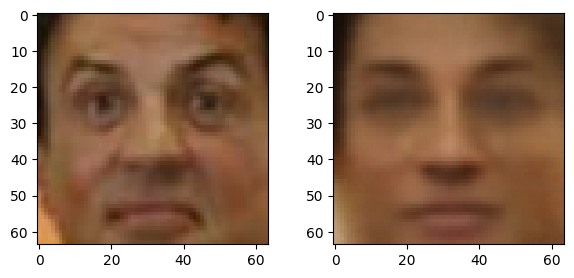

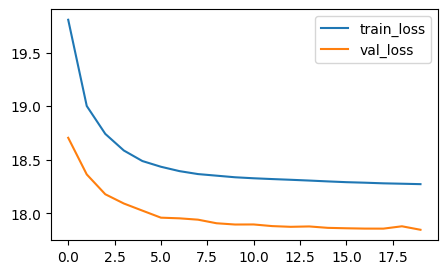

epoch: 20,  val_loss = 17.8469: 100%|██████████| 20/20 [03:22<00:00, 10.13s/it]


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae

autoencoder = Autoencoder().to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4, betas=(0.9, 0.999))

train(autoencoder, train_loader, val_loader, n_epochs=20)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

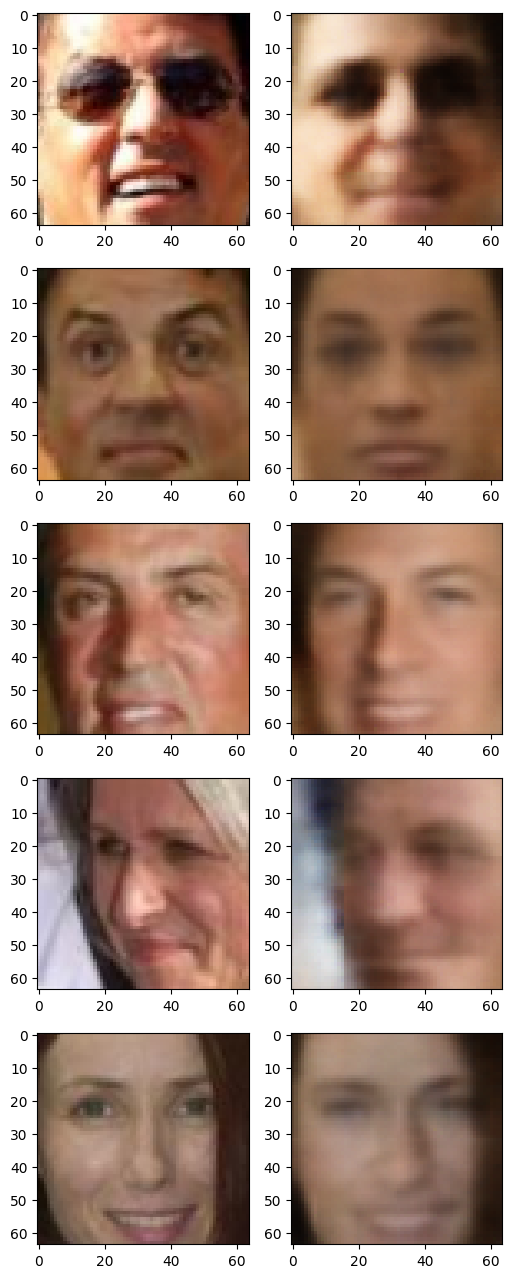

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      reconstruction, mu, logsigma = autoencoder(batch.to(device))
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break


plt.figure(figsize=(6, 16))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [1]:
# сгенерируем 25 рандомных векторов размера latent_space

z = np.random.randn(24, latent_code_size)
# z = np.array([np.random.normal(0, 1, 64) for i in range(24)])
output = autoencoder.sample(torch.FloatTensor(z).to(device))

# выводим полученные картинки
plt.figure(figsize=(8, 14))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 4, 4, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

NameError: name 'np' is not defined

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

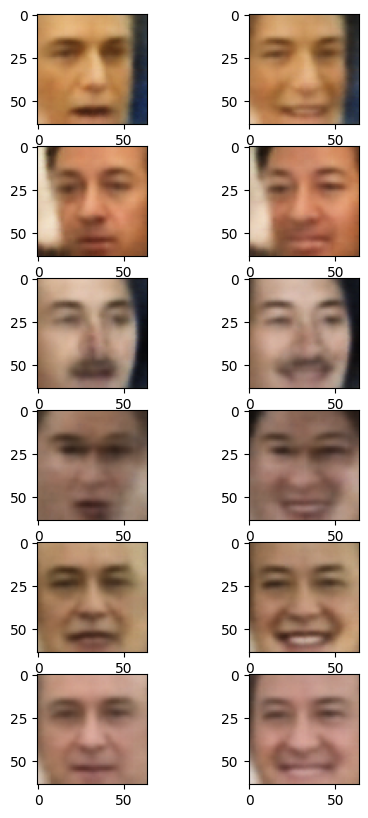

In [ ]:
# 1 - находим людей с улыыбками и без
people_with_smiles = torch.FloatTensor()
people_without_smiles = torch.FloatTensor()

for img, attr in zip(train_photos, train_attrs.Smiling):
    if attr > 1.0:
        if len(people_with_smiles) < 30:
            people_with_smiles = torch.cat((people_with_smiles, img.view(-1, 64, 64, 3)), dim=0)
    if attr < -1:
        if len(people_without_smiles) < 30:
            people_without_smiles = torch.cat((people_without_smiles, img.view(-1, 64, 64, 3)), dim=0)


# 2 - находим латентные вектора для людей с улыбками и без
latent_code_with_smiles = autoencoder.get_latent_vector(people_with_smiles.to(device))
latent_code_without_smiles = autoencoder.get_latent_vector(people_without_smiles.to(device))


# 3 - находим вектор улыбки
smile_code = (latent_code_with_smiles).mean(dim=0) - (latent_code_without_smiles).mean(dim=0)

# 4 - приделаем улыбку к грустному лицу
latent_code_without_smiles_new = latent_code_without_smiles + smile_code
people_new = autoencoder.sample(latent_code_without_smiles_new.to(device))


mad_man = autoencoder.sample(latent_code_without_smiles.to(device))
# выводим полученные картинки
plt.figure(figsize=(5, 10))
for i, (gt, res) in enumerate(zip(mad_man[4:10], people_new[4:10])):
  plt.subplot(6, 2, 2*i+1)
  plt.imshow(gt.cpu().detach().numpy())
  plt.subplot(6, 2, 2*i+2)
  plt.imshow(res.cpu().detach().numpy())

plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
data_lenght = len(train_dataset + test_dataset)
data_lenght

70000

torch.Size([32, 1, 28, 28])


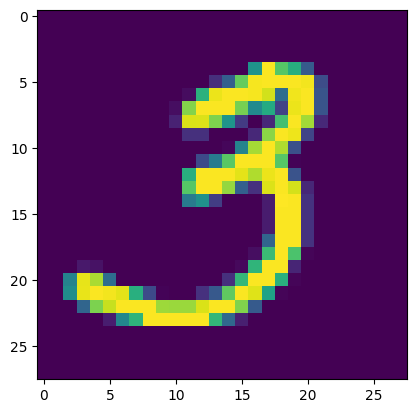

In [ ]:
for one in train_loader:
    print(one[0].shape)
    for img in one[0]:
        img = img.permute(1, 2, 0)
        plt.imshow(img)
        break
    break

# 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
latent_code_size = 32

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

        # encoder
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(in_features=3136, out_features=latent_code_size*2)


        # decoder
        self.de_fc = nn.Linear(in_features=latent_code_size, out_features=3136)
        self.deconv_block_2 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.deconv_block_1 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

        self.flatten = nn.Flatten()

    def encode(self, x):
        # <реализуйте forward проход энкодера, в качестве ваозвращаемых переменных -- mu и logsigma>
        # x = batch_size х 28 x 28 x 1
        x = x.permute(0, 3, 1, 2)               # batch_size х 1 x 28 x 28
        x = self.conv_block_1(x)                # batch_size x 32 х 14 x 14
        x = self.conv_block_2(x)                # batch_size x 64 х 7 x 7
        x = self.flatten(x)                     # batch_size х 3136
        x = self.fc(x)                          # batch_size х 64     (64 = latent_code_size*2)
        x = x.view(-1, 2, latent_code_size)     # batch_size х 2 x 32
        mu = x[:, 0, :]              # the first feature values as mean
        log_var = x[:, 1, :]         # the other feature values as variance

        return mu, log_var


    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>

            std = torch.exp(0.5 * logsigma)  # standard deviation
            eps = torch.randn_like(std)      # `randn_like` as we need the same size
            sample = mu + (eps * std)        # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
            # batch_size x 32


    def decode(self, z):
        # <реализуйте forward проход декодера, в качестве возвращаемой переменной -- reconstruction>
        x = self.de_fc(z)                       # batch_size х 3136
        x = x.view(-1, 64, 7, 7)               # batch_size x 64 х 7 x 7
        x = self.deconv_block_2(x)              # batch_size х 32 x 14 x 14
        x = self.deconv_block_1(x)              # batch_size х 1 x 28 x 28
        x = x.permute(0, 2, 3, 1)               # batch_size х 28 x 28 x 1
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера, в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent_code)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
def train_mnist(model, train_loader, val_loader, n_epochs=15, plotting=True):

    pbar = tqdm(range(n_epochs), colour='green')
    def plotting_net(train_losses, val_losses):
        plt.figure(figsize=(8, 3))
        plt.plot(train_losses, label="train_loss")
        plt.plot(val_losses, label="val_loss")
        plt.legend()
        plt.show()

    train_losses = []
    val_losses = []
    for epoch in pbar:
        model.train()
        train_losses_per_epoch = []
        for x_batch, _ in train_loader:
            x_batch = x_batch.permute(0, 2, 3, 1).to(device)
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(x_batch)
            loss = criterion(x_batch.float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item() / data_lenght)

        train_losses.append(np.mean(train_losses_per_epoch))


        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for x_batch, _ in val_loader:
                x_batch = x_batch.permute(0, 2, 3, 1).to(device)
                mu, logsigma, reconstruction = model(x_batch)
                loss = criterion(x_batch.float(), mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item() / data_lenght)

        val_losses.append(np.mean(val_losses_per_epoch))

        clear_output(wait=True)


        # после каждой эпохи смотрим как модель реконструирует изображение
        with torch.no_grad():
            for x_batch, _ in val_loader:
                x_batch = x_batch.permute(0, 2, 3, 1)
                _, _, reconstruction = model(x_batch.to(device))
                reconstruction = reconstruction.cpu().detach().numpy()
                x_batch = x_batch.numpy()
                fig, axes = plt.subplots(1, 4, figsize=(8, 3))
                axes[0].imshow(x_batch[0])
                axes[1].imshow(reconstruction[0])
                axes[2].imshow(x_batch[4])
                axes[3].imshow(reconstruction[4])
                plt.show()
                break

        if plotting:
            plotting_net(train_losses, val_losses)

        pbar.set_description(f'epoch: {epoch+1},  val_loss = {np.mean(val_losses_per_epoch):.4f}')

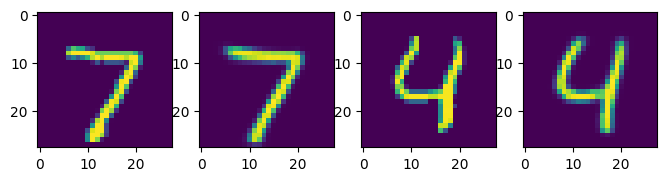

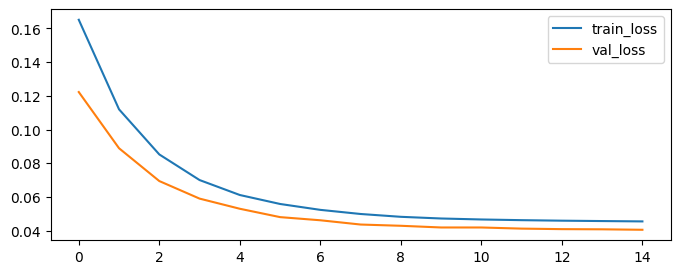

epoch: 15,  val_loss = 0.0406: 100%|██████████| 15/15 [08:05<00:00, 32.38s/it]


In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4, betas=(0.9, 0.999))
train_mnist(autoencoder, train_loader, test_loader)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

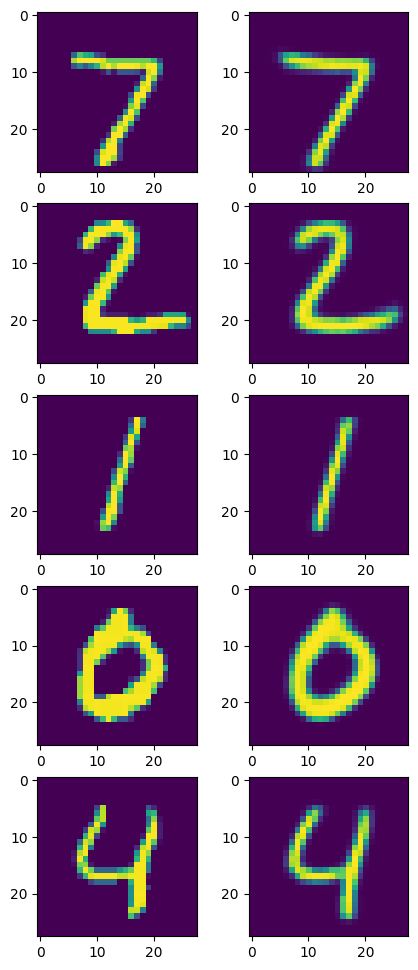

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder.eval()
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.permute(0, 2, 3, 1)
        _, _, reconstruction = autoencoder(x_batch.to(device))
        result = reconstruction.cpu().detach().numpy()
        ground_truth = x_batch.numpy()
        break


plt.figure(figsize=(5, 12))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

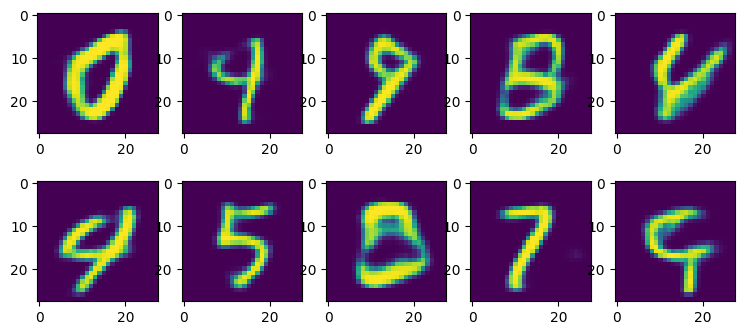

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
# z = np.array([np.random.normal(0, 1, latent_code_size) for i in range(10)])
z = np.random.randn(10, latent_code_size)
output = autoencoder.decode(torch.FloatTensor(z).to(device))

# выводим полученные картинки
plt.figure(figsize=(9, 4))
for i in range(output.shape[0]):
    plt.subplot(output.shape[0] // 5, 5, i + 1)
    generated = output[i].cpu().detach().numpy()
    plt.imshow(generated)

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

# 1
latent_vectors = torch.empty(0).to(device)
labels = []
autoencoder.eval()
with torch.no_grad():
    for img, label in test_dataset:
        img = img.view(-1,1,28,28).permute(0,2,3,1)
        mu, logsigma = autoencoder.encode(img.to(device))
        latent_code = autoencoder.gaussian_sampler(mu, logsigma)
        latent_vectors = torch.cat((latent_vectors, latent_code), dim=0)
        labels.append(label)

print(latent_vectors.shape)
len(labels)

torch.Size([10000, 32])


10000

In [ ]:
# 2 - применим TSNE
from sklearn.manifold import TSNE

coordinates = TSNE(n_components=2, learning_rate='auto').fit_transform(latent_vectors.cpu().detach().numpy())
coordinates.shape

(10000, 2)

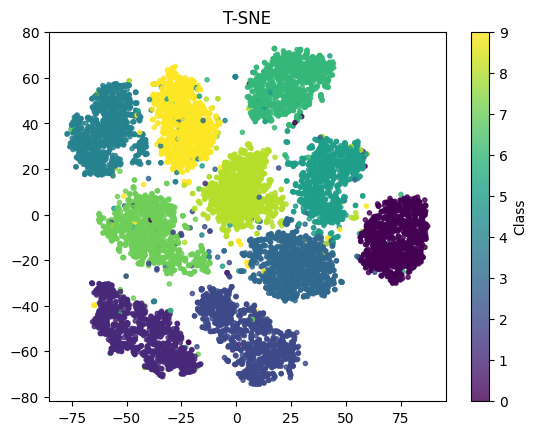

In [ ]:
# 3 - визуализация
x, y = zip(*coordinates)

scatter = plt.scatter(x, y, c=labels, marker='.', alpha=0.8, cmap='viridis')
# plt.legend(*scatter.legend_elements()) # возможно с этой строчкой появится легенда с цветами классов
plt.title("T-SNE")
plt.colorbar(label='Class')
plt.show()

Что вы думаете о виде латентного представления?

на графике видно, что латентные вектора каждого класса имеют примерно схожие значения.
также видно, что некоторые вектора находятся вне своего класса и даже заходят на территорию чужого класса. можно предположить, что это происходит в тех случаях, когда рукописная цифра написана совсем не красиво, не понятно и даже не похожа на себя

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)




![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
labels_length = len([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
latent_code_size = 32

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder. помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        self.flatten = nn.Flatten()

        # encoder
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Linear(in_features=3136+labels_length, out_features=latent_code_size*2)

        # decoder
        self.de_fc = nn.Linear(in_features=latent_code_size+labels_length, out_features=3136)
        self.deconv_block_2 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.deconv_block_1 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1))


    def encode(self, x, class_num):
        x = x.permute(0, 3, 1, 2)               # batch_size х 1 x 28 x 28
        x = self.conv_block_1(x)                # batch_size x 32 х 14 x 14
        x = self.conv_block_2(x)                # batch_size x 64 х 7 x 7
        x = self.flatten(x)                     # batch_size х 3136
        x = torch.cat((x, class_num), dim=1)    # batch_size х 3146   # concat
        x = self.fc(x)                          # batch_size х 64     (64 = latent_code_size*2)
        x = x.view(-1, 2, latent_code_size)     # batch_size х 2 x 32
        mu = x[:, 0, :]        # values as mean
        logsigma = x[:, 1, :]  # values as variance
        return mu, logsigma, class_num


    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)  # standard deviation
            eps = torch.randn_like(std)      # `randn_like` as we need the same size
            sample = mu + (eps * std)        # sampling as if coming from the input space
            return sample
        else:
            return mu


    def decode(self, latent_code, class_num):
        x = torch.cat((latent_code, class_num), dim=1)    # batch_size х 64   # concat
        x = self.de_fc(x)                       # batch_size х 3136
        x = x.view(-1, 64, 7, 7)                # batch_size x 64 х 7 x 7
        x = self.deconv_block_2(x)              # batch_size х 32 x 14 x 14
        x = self.deconv_block_1(x)              # batch_size х 1 x 28 x 28
        x = x.permute(0, 2, 3, 1)               # batch_size х 28 x 28 x 1
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)
        latent_code = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent_code, class_num)
        return mu, logsigma, reconstruction

In [ ]:
# def vectors_from_labels(labels):
#     # x = torch.zeros(len(labels), labels_length)
#     # for ind, label in enumerate(labels):
#     #     x[ind][label] = 1
#     x = torch.eye(labels_length)[labels]
#     return x

# for x_batch, labels in train_loader:
#     x_batch = x_batch.permute(0, 2, 3, 1).to(device)
#     labels = vectors_from_labels(labels).to(device)
#     print(labels)
#     break

# [size 32, 10]

In [ ]:
def vectors_from_labels(labels):
    # x = torch.zeros(len(labels), labels_length)
    # for ind, label in enumerate(labels):
    #     x[ind][label] = 1
    x = torch.eye(labels_length)[labels]
    return x


def train_for_cvae(model, train_loader, val_loader, n_epochs=1, plotting=True):

    pbar = tqdm(range(n_epochs), colour='green')
    def plotting_net(train_losses, val_losses):
        plt.figure(figsize=(8, 3))
        plt.plot(train_losses, label="train_loss")
        plt.plot(val_losses, label="val_loss")
        plt.legend()
        plt.show()

    train_losses = []
    val_losses = []
    for epoch in pbar:
        model.train()
        train_losses_per_epoch = []
        for x_batch, labels in train_loader:
            x_batch = x_batch.permute(0, 2, 3, 1).to(device)
            labels = vectors_from_labels(labels).to(device)
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(x_batch, labels)
            loss = criterion(x_batch.float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item() / data_lenght)

        train_losses.append(np.mean(train_losses_per_epoch))


        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for x_batch, labels in val_loader:
                x_batch = x_batch.permute(0, 2, 3, 1).to(device)
                labels = vectors_from_labels(labels).to(device)
                mu, logsigma, reconstruction = model(x_batch, labels)
                loss = criterion(x_batch.float(), mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item() / data_lenght)

        val_losses.append(np.mean(val_losses_per_epoch))

        clear_output(wait=True)


        # после каждой эпохи смотрим как модель реконструирует изображение
        with torch.no_grad():
            for x_batch, labels in val_loader:
                x_batch = x_batch.permute(0, 2, 3, 1)
                labels = vectors_from_labels(labels).to(device)
                _, _, reconstruction = model(x_batch.to(device), labels)
                reconstruction = reconstruction.cpu().detach().numpy()
                x_batch = x_batch.numpy()
                fig, axes = plt.subplots(1, 4, figsize=(8, 3))
                axes[0].imshow(x_batch[0])
                axes[1].imshow(reconstruction[0])
                axes[2].imshow(x_batch[4])
                axes[3].imshow(reconstruction[4])
                plt.show()
                break

        if plotting:
            plotting_net(train_losses, val_losses)

        pbar.set_description(f'epoch: {epoch+1},  val_loss = {np.mean(val_losses_per_epoch):.4f}')

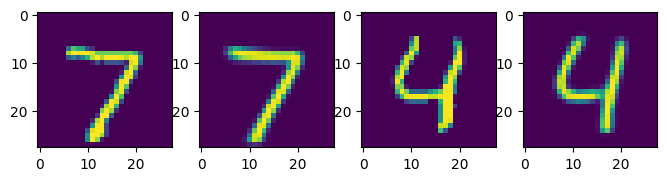

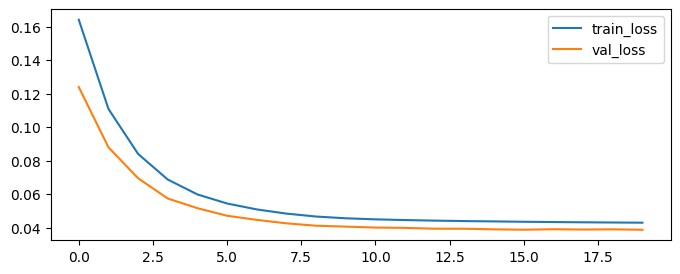

epoch: 20,  val_loss = 0.0388: 100%|██████████| 20/20 [10:58<00:00, 32.94s/it]


In [ ]:
criterion = loss_vae

autoencoder = CVAE().to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4, betas=(0.9, 0.999))
train_for_cvae(autoencoder, train_loader, test_loader, n_epochs=20)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

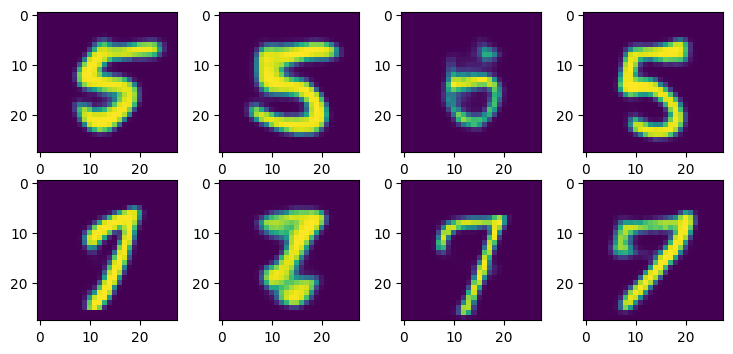

In [ ]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>

def vectors_from_labels(labels):
    x = torch.eye(labels_length)[labels]
    return x


# z = np.array([np.random.normal(0, 1, latent_code_size) for i in range(8)])
z = np.random.randn(8, latent_code_size)
z = torch.FloatTensor(z).to(device)
nums = [5,5,5,5,7,7,7,7]
class_num = vectors_from_labels(nums).to(device)

output = autoencoder.decode(z, class_num)

# выводим полученные картинки
plt.figure(figsize=(9, 4))
for i in range(output.shape[0]):
    plt.subplot(output.shape[0] // 4, 4, i + 1)
    generated = output[i].cpu().detach().numpy()
    plt.imshow(generated)

plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
# 1 - соберём латентные вектора и лэйблы
latent_vectors = torch.empty(0).to(device)
labels = []
autoencoder.eval()
with torch.no_grad():
    for img, label in test_dataset:
        img = img.view(-1,1,28,28).permute(0,2,3,1)
        mu, logsigma, class_num = autoencoder.encode(img.to(device), vectors_from_labels([label]).to(device))
        latent_code = autoencoder.gaussian_sampler(mu, logsigma)
        latent_vectors = torch.cat((latent_vectors, latent_code), dim=0)
        labels.append(label)


# 2 - применим TSNE
latent_vectors = latent_vectors.cpu().detach().numpy()
coordinates = TSNE(n_components=2, learning_rate='auto').fit_transform(latent_vectors)


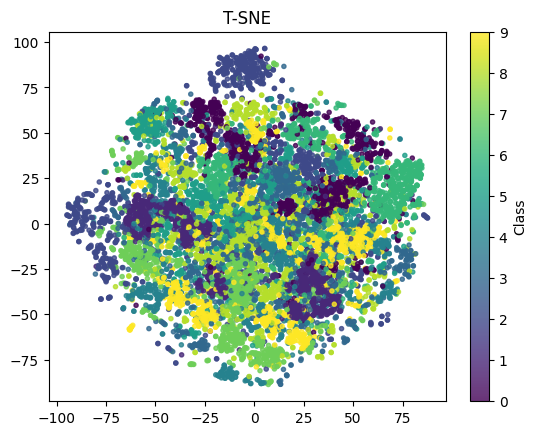

In [ ]:
# 3 - визуализация
x, y = zip(*coordinates)

plt.scatter(x, y, c=labels, marker='.', alpha=0.8, cmap='viridis')
plt.title("T-SNE")
plt.colorbar(label='Class')
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>